# Band-aid for Gaia refcat errors for Jointcal on  HSC RC2


January 4-6 2021

After switching to the Gaia refcat on RC2 to we noticed that the solution walks away from the reference catalog. Hypothesis: The refcat errors are too large and thus the refcat is being underwieghted. 

See: DM-28173

Symptoms are the stellar locus width increased and the measured positions - ref cat positions increased. This didn't appear in the relative astrometry metric because the shifts are coherent.


## Intro to metrics computed

This is basically the same notebook as https://github.com/yalsayyad/dm_notebooks/blob/master/calibration/run21i_validate_drp.ipynb
but with HSC RC2 with the Gaia refcat.

We care about both relative astrometry and absolute astrometry.

### Relative astrometry

Validate_drp computes astrometric and photometric repeatabliity metrics per the SRD. See ls.st/LPM-17 for more info.
The astrometric repeatability metrics `AM1`, `AM2`, and `AM3` is the median RMS of distances between star pairs. 

The ELI5 version courtesy of John Parejko is: "Take a pair of stars ~5' apart on the sky. Any time that pair is seen in a single visit, record their separation. Compute the RMS of all those separations...that RMS is one datapoint. Do that for all such pairs separated by ~5': that is the histogram shown" below. The median of all those RMS's is the AM1. 

The 1, 2, 3 correspond to pairs 5', 20' and 200' apart to represent scales of an individual sensor, a raft, and
the camera. 


The other validate_drp astrometry plot prints the naive distribution of the RMS variation in the position of stars. This is the metric that one thinks of first when they hear "repeatabiliy" and is the analog of PA1. 

Code that computes AMx can be found in:
* `https://github.com/lsst/validate_drp/blob/tickets/DM-18638/python/lsst/validate/drp/calcsrd/amx.py`


###  Absolute astrometry

We don't have a squash metric for this yet, but `visitAnalysis` in the pipe_analysis package computes this.


## Data (links to QA plots and configs)

Ran `visitAnalysis` and `validateDRP` on the following 2 configurations.


---
| link to QA plots                                                        | title | Description | Why | 
|-------------------------------------------------------------------------|-------|----------------------------|------|
| https://lsst.ncsa.illinois.edu/~emorgan2/w_2020_50_qaplots            | w50 | w50 (Gaia) | | 
| https://lsst.ncsa.illinois.edu/~yusra/RC_QA/w_2020_50_ps1        | w50_ps1 | w50 w/ jointcal and obs_subaru on w49 (PS1) | Control. To compare with just the refcat change. Effect of reverting to PS1 | 
| https://lsst.ncsa.illinois.edu/~yusra/RC_QA/w_2020_50_refErr10   | w50_refErr10 | w50 `astrometryReferenceErr=10.0` (Gaia) | bandaid | 
| https://lsst.ncsa.illinois.edu/~yusra/RC_QA/w_2020_50_fixErr   | w50_fixErr | w01 + DM-28233 (Gaia) | Proposed fix | 


Expectation: One change that came with the PS1->Gaia is that Gaia comes with per-object position errors. We know from https://github.com/yalsayyad/dm_notebooks/blob/master/calibration/run21i_validate_drp.ipynb that jointcal the reference errors affect how strictly it tries to adhere to the reference catalog. Too roomy and the fit walks away from the reference catalog. 

My hypothesis is that this is what happened here and I want to find a way to dial it back. 

Update: Eli found refcat errors are in the wrong units and posted fix on DM-28233. Tested as:  `w50_fixErr` 

In [1]:
import sys
import os
import numpy as np
import copy
import pickle
import json
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import seaborn as sns
import pandas as pd
%matplotlib inline  
sns.set_palette('Dark2')
sns.set(context='talk',
        style='whitegrid',
        palette='deep',
        font='sans-serif',
        font_scale=1,
        color_codes=True,
        rc={'text.usetex': False})

In [19]:
DIR_DICT_DC2 = {
    #"w50_refErr10": "/datasets/hsc/repo/rerun/private/yusra/RC2/w_2020_50_refErr10/plots/validateDrp/matchedVisitMetrics",
    #"w50_ps1": "/datasets/hsc/repo/rerun/private/yusra/RC2/w_2020_50_ps1/plots/validateDrp/matchedVisitMetrics",
    #"w50": "/datasets/hsc/repo/rerun/RC/w_2020_50/DM-28140/validateDrp/matchedVisitMetrics",
    "w50_fixErr": "/datasets/hsc/repo/rerun/private/yusra/RC2/w_2020_50_fixErr/plots/validateDrp/matchedVisitMetrics",
}

rowList = []

for TRACT in (9813, 9697, 9615):
    for FILTER in ['HSC-%s'%(band) for band in 'GRIZY']:
        for dirName, DIR in DIR_DICT_DC2.items():
            dictDF = {}
            fname = "matchedVisit_%s" % (FILTER)
            path = os.path.join(DIR, str(TRACT), FILTER, fname + '.json')
            print(path)
            try:
                with open(path) as json_file:
                    data = json.load(json_file)
            except:
                continue
            print("loaded")
            values = [d['value'] for d in data['measurements']]
            metrics = [d['metric'].replace('validate_drp.', '') for d in data['measurements']]
            for metric, value in zip(metrics, values):
                dictDF[metric] = value
                dictDF['tract'] = TRACT
                dictDF['filter'] = FILTER
                dictDF['config'] = dirName
            rowList.append(dictDF)

dffixErr = pd.DataFrame(rowList)

/datasets/hsc/repo/rerun/private/yusra/RC2/w_2020_50_fixErr/plots/validateDrp/matchedVisitMetrics/9813/HSC-G/matchedVisit_HSC-G.json
loaded
/datasets/hsc/repo/rerun/private/yusra/RC2/w_2020_50_fixErr/plots/validateDrp/matchedVisitMetrics/9813/HSC-R/matchedVisit_HSC-R.json
loaded
/datasets/hsc/repo/rerun/private/yusra/RC2/w_2020_50_fixErr/plots/validateDrp/matchedVisitMetrics/9813/HSC-I/matchedVisit_HSC-I.json
loaded
/datasets/hsc/repo/rerun/private/yusra/RC2/w_2020_50_fixErr/plots/validateDrp/matchedVisitMetrics/9813/HSC-Z/matchedVisit_HSC-Z.json
loaded
/datasets/hsc/repo/rerun/private/yusra/RC2/w_2020_50_fixErr/plots/validateDrp/matchedVisitMetrics/9813/HSC-Y/matchedVisit_HSC-Y.json
loaded
/datasets/hsc/repo/rerun/private/yusra/RC2/w_2020_50_fixErr/plots/validateDrp/matchedVisitMetrics/9697/HSC-G/matchedVisit_HSC-G.json
loaded
/datasets/hsc/repo/rerun/private/yusra/RC2/w_2020_50_fixErr/plots/validateDrp/matchedVisitMetrics/9697/HSC-R/matchedVisit_HSC-R.json
loaded
/datasets/hsc/repo/r

In [3]:
unitsDict = {}
for name, unit, disc in [(d['name'], d['unit'], d['description']) for d in data['metrics']]:
    unitsDict[name.replace('validate_drp.', '')] = (unit, disc)

In [4]:
unitsDict

{'PA1': ('mmag',
  'The maximum rms of the unresolved source magnitude distribution around the mean value.'),
 'PF1_minimum_gri': ('%',
  'The maximum fraction of magnitudes deviating by more than PA2_minimum_gri from mean.'),
 'PF1_design_gri': ('%',
  'The maximum fraction of magnitudes deviating by more than PA2_design_gri from mean.'),
 'PF1_stretch_gri': ('%',
  'The maximum fraction of magnitudes deviating by more than PA2_stretch_gri from mean.'),
 'PF1_minimum_uzy': ('%',
  'The maximum fraction of magnitudes deviating by more than PA2_minimum_uzy from mean.'),
 'PF1_design_uzy': ('%',
  'The maximum fraction of magnitudes deviating by more than PA2_design_uzy from mean.'),
 'PF1_stretch_uzy': ('%',
  'The maximum fraction of magnitudes deviating by more than PA2_stretch_uzy from mean.'),
 'PA2_minimum_gri': ('mmag',
  'At most PF1_minimum_gri % of magnitudes may deviate by more than this magnitude from the mean.'),
 'PA2_design_gri': ('mmag',
  'At most PF1_design_gri % of mag

In [21]:
df2 = pd.concat([df, dffixErr])

In [40]:
df2[['AM1', 'AM2','AM3','config']]

,AM1,AM2,AM3,config
0,4.599104,4.674071,NaN,w50_refErr10
1,4.634609,4.683638,NaN,w50_ps1
2,4.987492,5.083376,NaN,w50
3,5.209379,4.649905,NaN,w50_refErr10
4,5.136466,4.668592,NaN,w50_ps1
5,4.992864,4.971158,NaN,w50
6,4.704458,5.144493,NaN,w50_refErr10
7,4.729630,5.074105,NaN,w50_ps1
8,4.791790,4.860627,NaN,w50
9,5.633133,5.770187,NaN,w50_refErr10


## Astrometric Repeatability

### Comparison of the AMx Metrics:

In [6]:
df.columns

Index(['AM1', 'tract', 'filter', 'config', 'AD1_design', 'AF1_design',
       'AD1_minimum', 'AF1_minimum', 'AD1_stretch', 'AF1_stretch', 'AM2',
       'AD2_design', 'AF2_design', 'AD2_minimum', 'AF2_minimum', 'AD2_stretch',
       'AF2_stretch', 'AM3', 'AD3_design', 'AF3_design', 'AD3_minimum',
       'AF3_minimum', 'AD3_stretch', 'AF3_stretch', 'PA1', 'PA2_design_gri',
       'PF1_design_gri', 'PA2_minimum_gri', 'PF1_minimum_gri',
       'PA2_stretch_gri', 'PF1_stretch_gri', 'TE1', 'TE2', 'psfPhotRepStar1',
       'psfPhotRepStar2', 'psfPhotRepStar3', 'psfPhotRepStar4',
       'modelPhotRepGal1', 'modelPhotRepGal2', 'modelPhotRepStar1',
       'modelPhotRepStar2', 'modelPhotRepGal3', 'modelPhotRepGal4',
       'modelPhotRepStar3', 'modelPhotRepStar4', 'PA2_design_uzy',
       'PF1_design_uzy', 'PA2_minimum_uzy', 'PF1_minimum_uzy',
       'PA2_stretch_uzy', 'PF1_stretch_uzy'],
      dtype='object')

/home/yusra/.local/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


<Figure size 144x432 with 0 Axes>

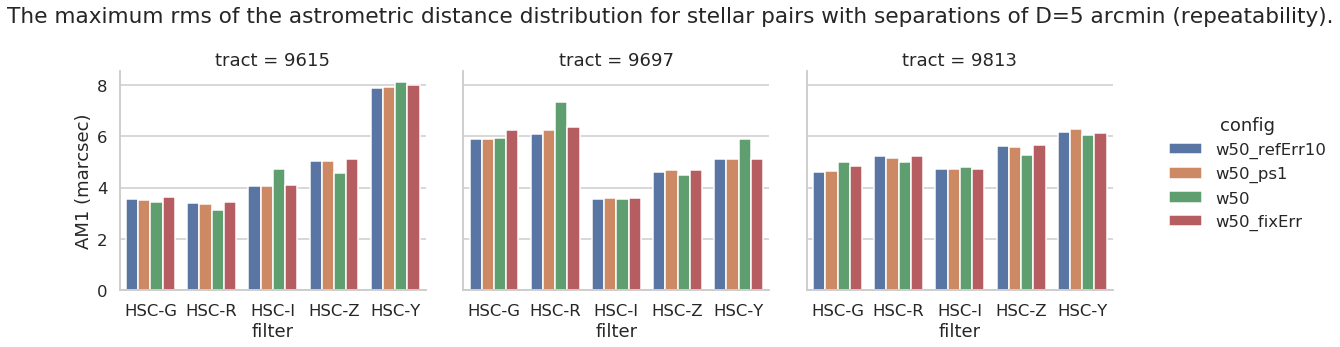

/home/yusra/.local/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


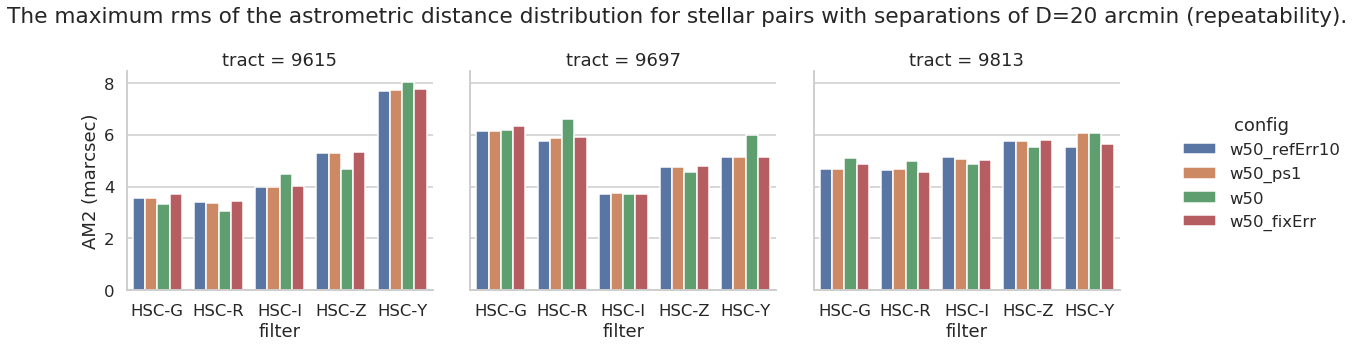

/home/yusra/.local/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


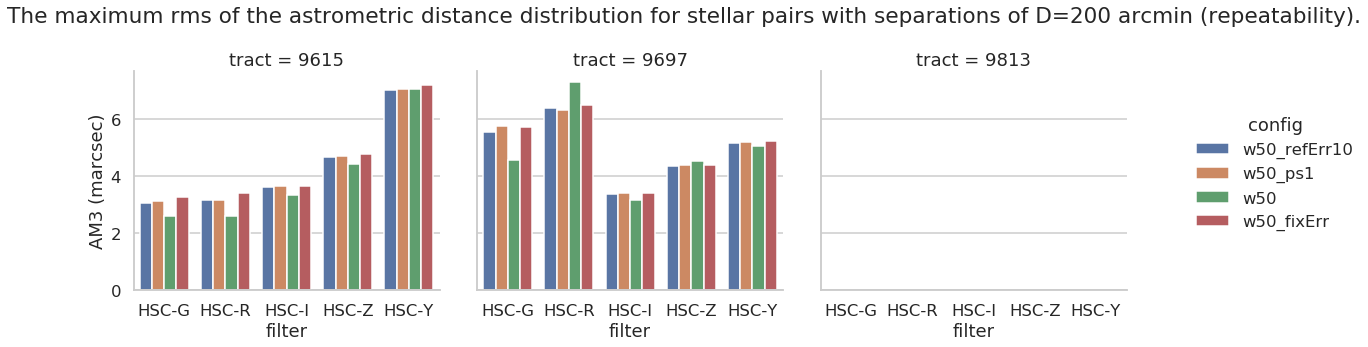

/home/yusra/.local/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


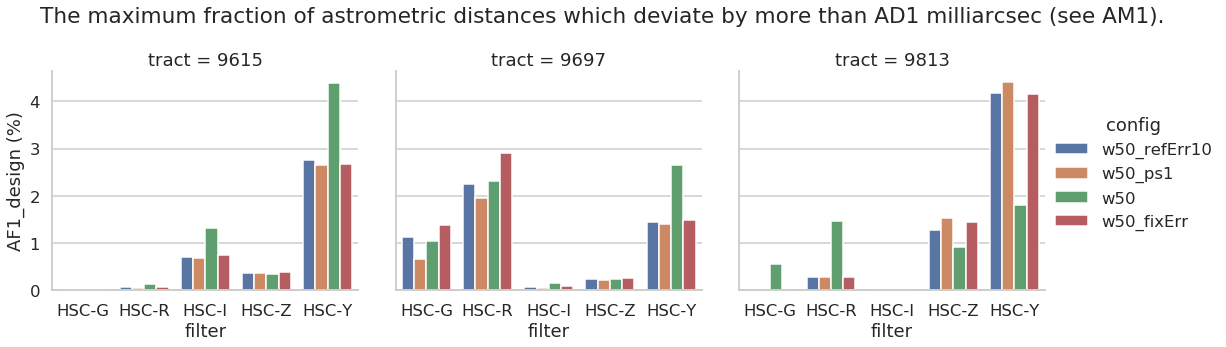

/home/yusra/.local/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


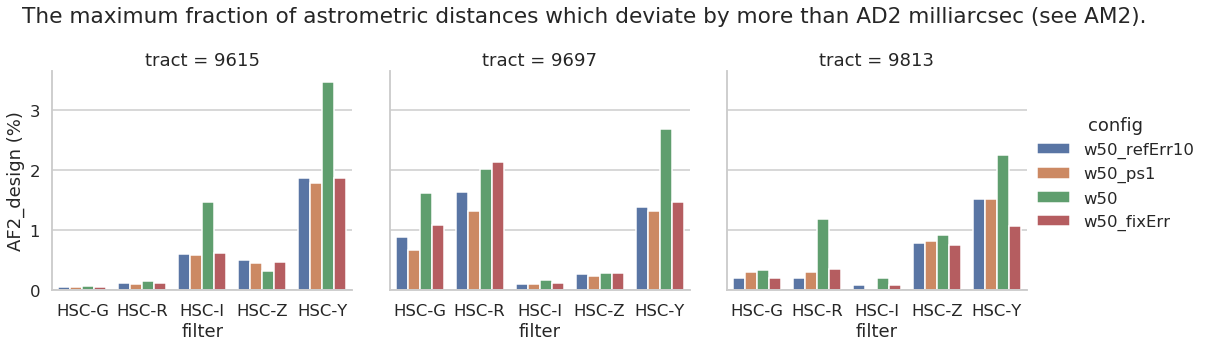

/home/yusra/.local/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


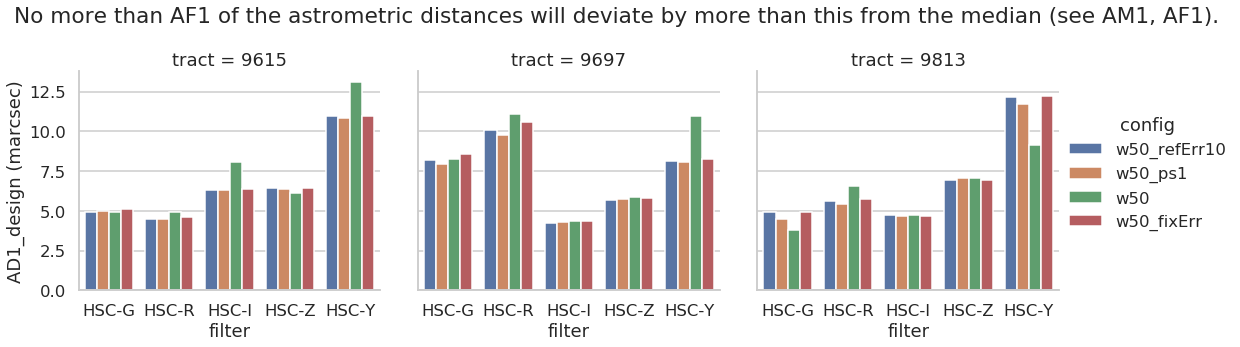

/home/yusra/.local/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


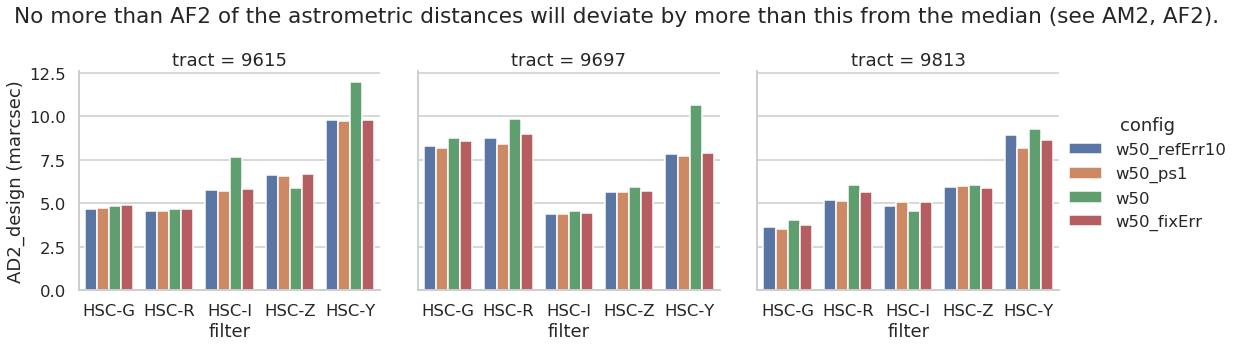

/home/yusra/.local/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


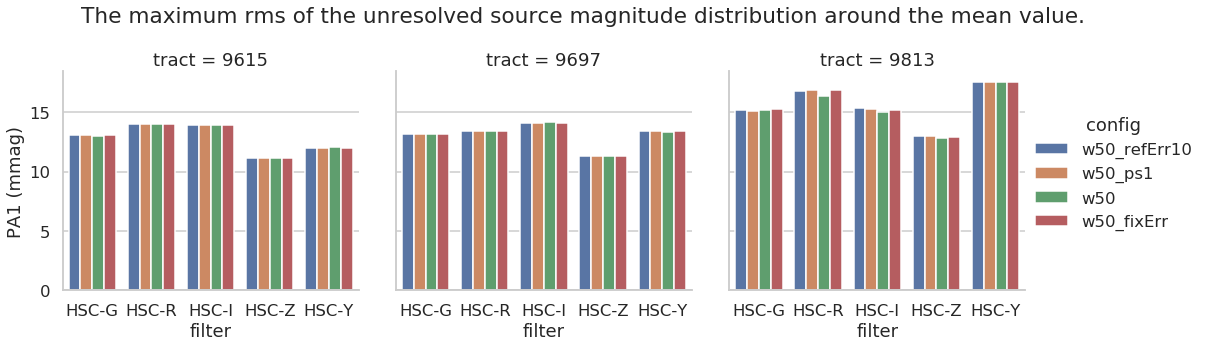

In [24]:
fig = plt.figure(figsize=(2, 6))
cols = ["AM1", "AM2", "AM3", 'AF1_design', 'AF2_design', 'AD1_design', 'AD2_design', 'PA1']
for col in cols:
    ax = sns.factorplot(x="filter", y=col, data=df2,
                        hue="config", col="tract", kind="bar")
    ax.fig.suptitle(unitsDict[col][1])
    ax.fig.subplots_adjust(top=0.8)
    ax.set_ylabels("%s (%s)"%(col, unitsDict[col][0]))
    #plt.tight_layout()
    #plt.savefig('/home/yusra/public_html/download/refErr-%s.png'%(col))
    plt.show()

### Comparison of all the validate DRP metrics:

In [ ]:
fig = plt.figure(figsize=(2, 6))
for j, col in enumerate(df.columns):
    try:
        ax = sns.factorplot(x="filter", y=col, data=df2,
                        hue="config", col="tract", kind="bar")
        ax.fig.suptitle(unitsDict[col][1])
        ax.fig.subplots_adjust(top=0.8)
        ax.set_ylabels("%s (%s)"%(col, unitsDict[col][0]))
        plt.show()
    except:
        pass

## Astrometric Match with the Input Catalog

Jeff Carlin is working on a metric that gets loaded into squash for this. In the meantime, we have visitAnalysis plots and coaddAnalysis plots from pipe_analysis:

In [41]:
%%html

<h2> visit = 1228 (distance)
    
<table>
  <tr>
    <th> rerun</th>
    <th> VS. Gaia</th>
    <th> VS. PS1 </th>
  </tr>
  <tr>
    <td>w50 <br> (Gaia) </td>
    <td><img src="https://lsst.ncsa.illinois.edu/~yusra/RC_QA/w_2020_50_visitAnalysis/HSC-I/tract-9813/visit-1228/plot-v1228-matches_distance-sky-stars.png" alt="w50 vs gaia" width=500></td>
    <td><img src="https://lsst.ncsa.illinois.edu/~emorgan2/w_2020_50_qaplots/HSC-I/tract-9813/visit-1228/plot-v1228-matches_distance-sky-stars.png" alt="w50 vs ps1" width=500></td>
  </tr>

  <tr>
    <td>w50_ps1<br>  (PS1) </td>
    <td> <img src="https://lsst.ncsa.illinois.edu/~yusra/RC_QA/w_2020_50_ps1_visitAnalysis/HSC-I/tract-9813/visit-1228/plot-v1228-matches_distance-sky-stars.png" alt="w50_ps1 vs gaia" width=500></td>
    <td> <img src="https://lsst.ncsa.illinois.edu/~yusra/RC_QA/w_2020_50_ps1/HSC-I/tract-9813/visit-1228/plot-v1228-matches_distance-sky-stars.png" alt="w50_ps1 vs ps1" width=500></td>
  </tr>

  <tr>
    <td>w50_refErr10 <br> (Gaia)</td>
    <td> <img src="https://lsst.ncsa.illinois.edu/~yusra/RC_QA/w_2020_50_refErr10_visitAnalysis/HSC-I/tract-9813/visit-1228/plot-v1228-matches_distance-sky-stars.png" alt="w50_refErr10 vs gaia" width=500></td>
    <td> <img src="https://lsst.ncsa.illinois.edu/~yusra/RC_QA/w_2020_50_refErr10/HSC-I/tract-9813/visit-1228/plot-v1228-matches_distance-sky-stars.png" alt="w50_refErr10 vs PS1" width=500></td>
  </tr>

  <tr>
    <td>w50_fixErr <br> (Gaia)</td>
    <td> <img src="https://lsst.ncsa.illinois.edu/~yusra/RC_QA/w_2020_50_fixErr_visitAnalysis/HSC-I/tract-9813/visit-1228/plot-v1228-matches_distance-sky-stars.png" alt="w50_fixErr vs gaia" width=500></td>
    <td> <img src="https://lsst.ncsa.illinois.edu/~yusra/RC_QA/w_2020_50_fixErr/HSC-I/tract-9813/visit-1228/plot-v1228-matches_distance-sky-stars.png" alt="w50_fixErr vs PS1" width=500></td>
  </tr>


</table>

rerun,VS. Gaia,VS. PS1
w50 (Gaia),,
w50_ps1 (PS1),,
w50_refErr10 (Gaia),,
w50_fixErr (Gaia),,


In [42]:
%%html

<h2> visit = 1228 (ra)
    
<table>
  <tr>
    <th> rerun</th>
    <th> VS. Gaia</th>
    <th> VS. PS1 </th>
  </tr>
  <tr>
    <td>w50 <br> (Gaia) </td>
    <td><img src="https://lsst.ncsa.illinois.edu/~yusra/RC_QA/w_2020_50_visitAnalysis/HSC-I/tract-9813/visit-1228/plot-v1228-matches_raCosDec-sky-stars.png" alt="w50 vs gaia" width=500></td>
    <td><img src="https://lsst.ncsa.illinois.edu/~emorgan2/w_2020_50_qaplots/HSC-I/tract-9813/visit-1228/plot-v1228-matches_raCosDec-sky-stars.png" alt="w50 vs ps1" width=500></td>
  </tr>

  <tr>
    <td>w50_ps1<br>  (PS1) </td>
    <td> <img src="https://lsst.ncsa.illinois.edu/~yusra/RC_QA/w_2020_50_ps1_visitAnalysis/HSC-I/tract-9813/visit-1228/plot-v1228-matches_raCosDec-sky-stars.png" alt="w50_ps1 vs gaia" width=500></td>
    <td> <img src="https://lsst.ncsa.illinois.edu/~yusra/RC_QA/w_2020_50_ps1/HSC-I/tract-9813/visit-1228/plot-v1228-matches_raCosDec-sky-stars.png" alt="w50_ps1 vs ps1" width=500></td>
  </tr>

  <tr>
    <td>w50_refErr10 <br> (Gaia)</td>
    <td> <img src="https://lsst.ncsa.illinois.edu/~yusra/RC_QA/w_2020_50_refErr10_visitAnalysis/HSC-I/tract-9813/visit-1228/plot-v1228-matches_raCosDec-sky-stars.png" alt="w50_refErr10 vs gaia" width=500></td>
    <td> <img src="https://lsst.ncsa.illinois.edu/~yusra/RC_QA/w_2020_50_refErr10/HSC-I/tract-9813/visit-1228/plot-v1228-matches_raCosDec-sky-stars.png" alt="w50_refErr10 vs PS1" width=500></td>
  </tr>

  <tr>
    <td>w50_fixErr <br> (Gaia)</td>
    <td> <img src="https://lsst.ncsa.illinois.edu/~yusra/RC_QA/w_2020_50_fixErr_visitAnalysis/HSC-I/tract-9813/visit-1228/plot-v1228-matches_raCosDec-sky-stars.png" alt="w50_fixErr vs gaia" width=500></td>
    <td> <img src="https://lsst.ncsa.illinois.edu/~yusra/RC_QA/w_2020_50_fixErr/HSC-I/tract-9813/visit-1228/plot-v1228-matches_raCosDec-sky-stars.png" alt="w50_fixErr vs PS1" width=500></td>
  </tr>


</table>

rerun,VS. Gaia,VS. PS1
w50 (Gaia),,
w50_ps1 (PS1),,
w50_refErr10 (Gaia),,
w50_fixErr (Gaia),,


In [43]:
%%html

<h2> visit = 1228 (dec)
    
<table>
  <tr>
    <th> rerun</th>
    <th> VS. Gaia</th>
    <th> VS. PS1 </th>
  </tr>
  <tr>
    <td>w50 <br> (Gaia) </td>
    <td><img src="https://lsst.ncsa.illinois.edu/~yusra/RC_QA/w_2020_50_visitAnalysis/HSC-I/tract-9813/visit-1228/plot-v1228-matches_dec-sky-stars.png" alt="w50 vs gaia" width=500></td>
    <td><img src="https://lsst.ncsa.illinois.edu/~emorgan2/w_2020_50_qaplots/HSC-I/tract-9813/visit-1228/plot-v1228-matches_dec-sky-stars.png" alt="w50 vs ps1" width=500></td>
  </tr>

  <tr>
    <td>w50_ps1<br>  (PS1) </td>
    <td> <img src="https://lsst.ncsa.illinois.edu/~yusra/RC_QA/w_2020_50_ps1_visitAnalysis/HSC-I/tract-9813/visit-1228/plot-v1228-matches_dec-sky-stars.png" alt="w50_ps1 vs gaia" width=500></td>
    <td> <img src="https://lsst.ncsa.illinois.edu/~yusra/RC_QA/w_2020_50_ps1/HSC-I/tract-9813/visit-1228/plot-v1228-matches_dec-sky-stars.png" alt="w50_ps1 vs ps1" width=500></td>
  </tr>

  <tr>
    <td>w50_refErr10 <br> (Gaia)</td>
    <td> <img src="https://lsst.ncsa.illinois.edu/~yusra/RC_QA/w_2020_50_refErr10_visitAnalysis/HSC-I/tract-9813/visit-1228/plot-v1228-matches_dec-sky-stars.png" alt="w50_refErr10 vs gaia" width=500></td>
    <td> <img src="https://lsst.ncsa.illinois.edu/~yusra/RC_QA/w_2020_50_refErr10/HSC-I/tract-9813/visit-1228/plot-v1228-matches_dec-sky-stars.png" alt="w50_refErr10 vs PS1" width=500></td>
  </tr>

  <tr>
    <td>w50_fixErr <br> (Gaia)</td>
    <td> <img src="https://lsst.ncsa.illinois.edu/~yusra/RC_QA/w_2020_50_fixErr_visitAnalysis/HSC-I/tract-9813/visit-1228/plot-v1228-matches_dec-sky-stars.png" alt="w50_fixErr vs gaia" width=500></td>
    <td> <img src="https://lsst.ncsa.illinois.edu/~yusra/RC_QA/w_2020_50_fixErr/HSC-I/tract-9813/visit-1228/plot-v1228-matches_dec-sky-stars.png" alt="w50_fixErr vs PS1" width=500></td>
  </tr>


</table>

rerun,VS. Gaia,VS. PS1
w50 (Gaia),,
w50_ps1 (PS1),,
w50_refErr10 (Gaia),,
w50_fixErr (Gaia),,


In [44]:
%%html

<h2> visit = 30504 distance
    

<table>
  <tr>
    <th> rerun</th>
    <th> VS. Gaia</th>
    <th> VS. PS1 </th>
  </tr>
  <tr>
    <td>w50 <br> (Gaia) </td>
    <td><img src="https://lsst.ncsa.illinois.edu/~yusra/RC_QA/w_2020_50_visitAnalysis/HSC-I/tract-9813/visit-30504/plot-v30504-matches_distance-sky-stars.png" alt="w50 vs gaia" width=500></td>
    <td><img src="https://lsst.ncsa.illinois.edu/~emorgan2/w_2020_50_qaplots/HSC-I/tract-9813/visit-30504/plot-v30504-matches_distance-sky-stars.png" alt="w50 vs ps1" width=500></td>
  </tr>

  <tr>
    <td>w50_ps1<br>  (PS1) </td>
    <td> <img src="https://lsst.ncsa.illinois.edu/~yusra/RC_QA/w_2020_50_ps1_visitAnalysis/HSC-I/tract-9813/visit-30504/plot-v30504-matches_distance-sky-stars.png" alt="w50_ps1 vs gaia" width=500></td>
    <td> <img src="https://lsst.ncsa.illinois.edu/~yusra/RC_QA/w_2020_50_ps1/HSC-I/tract-9813/visit-30504/plot-v30504-matches_distance-sky-stars.png" alt="w50_ps1 vs ps1" width=500></td>
  </tr>

  <tr>
    <td>w50_refErr10 <br> (Gaia)</td>
    <td> <img src="https://lsst.ncsa.illinois.edu/~yusra/RC_QA/w_2020_50_refErr10_visitAnalysis/HSC-I/tract-9813/visit-30504/plot-v30504-matches_distance-sky-stars.png" alt="w50_refErr10 vs gaia" width=500></td>
    <td> <img src="https://lsst.ncsa.illinois.edu/~yusra/RC_QA/w_2020_50_refErr10/HSC-I/tract-9813/visit-30504/plot-v30504-matches_distance-sky-stars.png" alt="w50_refErr10 vs PS1" width=500></td>
  </tr>

  <tr>
    <td>w50_fixErr <br> (Gaia)</td>
    <td> <img src="https://lsst.ncsa.illinois.edu/~yusra/RC_QA/w_2020_50_fixErr_visitAnalysis/HSC-I/tract-9813/visit-30504/plot-v30504-matches_distance-sky-stars.png" alt="w50_fixErr vs gaia" width=500></td>
    <td> <img src="https://lsst.ncsa.illinois.edu/~yusra/RC_QA/w_2020_50_fixErr/HSC-I/tract-9813/visit-30504/plot-v30504-matches_distance-sky-stars.png" alt="w50_fixErr vs PS1" width=500></td>
  </tr>
</table>

rerun,VS. Gaia,VS. PS1
w50 (Gaia),,
w50_ps1 (PS1),,
w50_refErr10 (Gaia),,
w50_fixErr (Gaia),,


## Stellar Locus

From colorAnalysis:

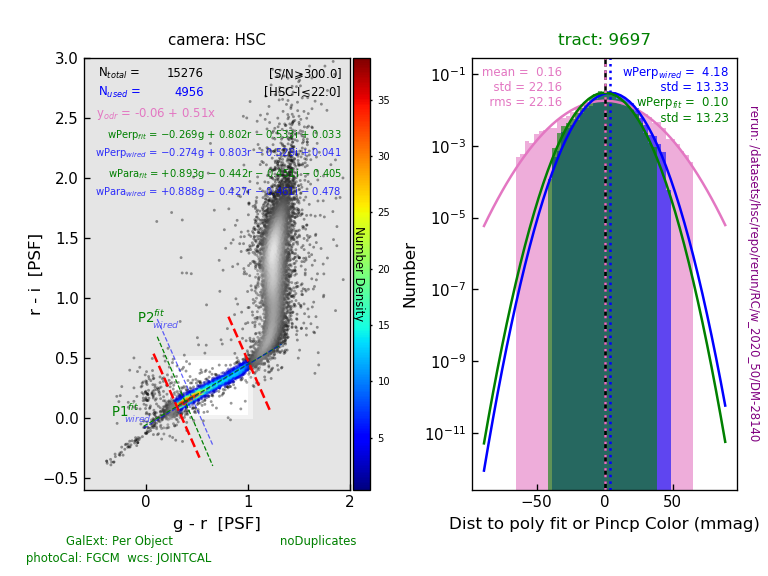

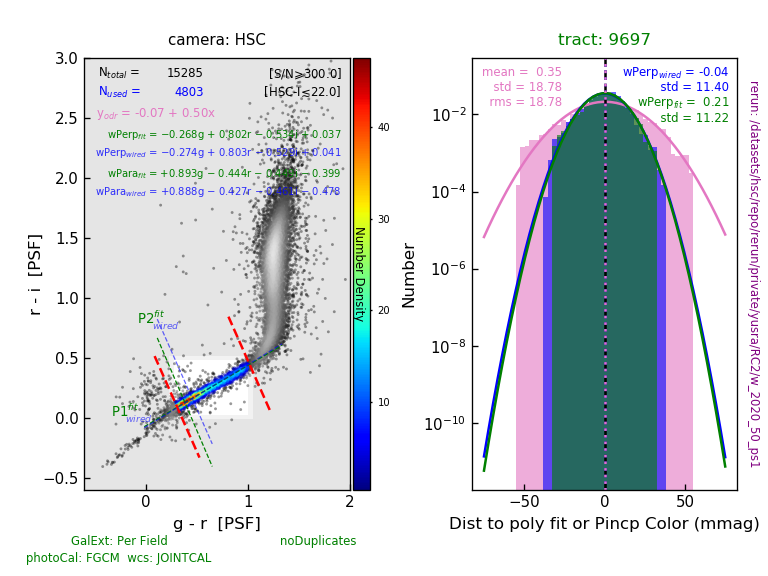

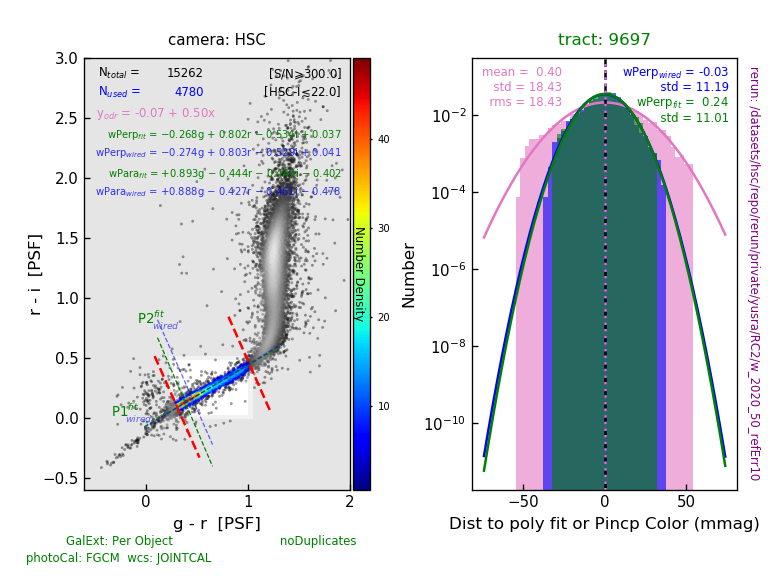

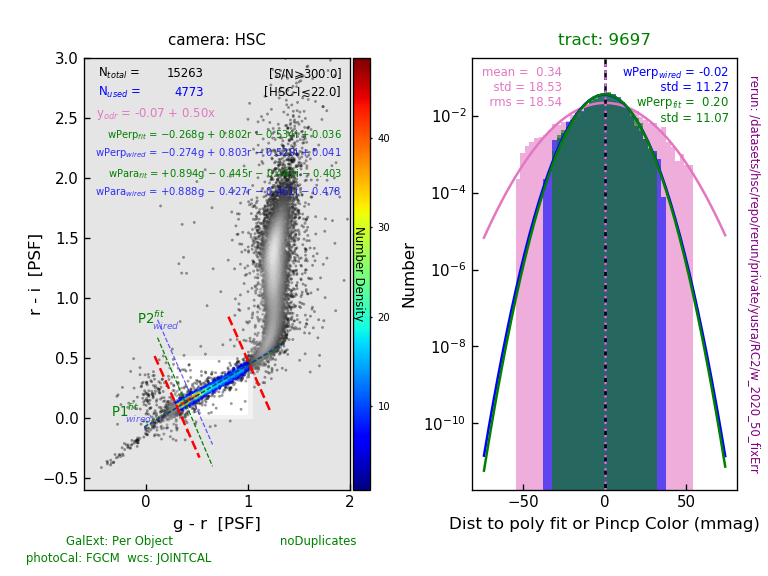

In [45]:
from IPython.display import display, Image
im1 = Image("https://lsst.ncsa.illinois.edu/~emorgan2/w_2020_50_qaplots/color/tract-9697/plot-t9697-griPSF-wFit-fit.png", width=600,)
im2 = Image("https://lsst.ncsa.illinois.edu/~yusra/RC_QA/w_2020_50_ps1/color/tract-9697/plot-t9697-griPSF-wFit-fit.png", width=600,)
im3 = Image("https://lsst.ncsa.illinois.edu/~yusra/RC_QA/w_2020_50_refErr10/color/tract-9697/plot-t9697-griPSF-wFit-fit.png", width=600,)
im4 = Image("https://lsst.ncsa.illinois.edu/~yusra/RC_QA/w_2020_50_fixErr/color/tract-9697/plot-t9697-griPSF-wFit-fit.png", width=600,)
display(im1, im2, im3, im4)